In [1]:
import numpy as np
import sys
sys.path.append("/users/tom/git/neon_blink_detection/")

import notebooks.plotting_functions as pf
from src.post_processing import smooth_proba
import pickle
import matplotlib.pyplot as plt
import joblib



/cluster/anaconda3/envs/tom_py310/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


**Load frames and features, predict blinks, load ground truth, compute IOU**

In [6]:
iclip = 0

clip_names = pf.get_clip_names()

# Load data and features
ts, features, left_images, right_images = pf.load_imgs_and_features(clip_names[iclip])

# Predict blinks
predicted_blink_on, predicted_blink_off, blink_events, proba = pf.predict_blinks(ts, features)

# Load ground truth blinks
blink_on_idx, blink_off_idx, _ = pf.load_gt_blinks(clip_names[iclip], ts)

pred = [(predicted_blink_on[x], predicted_blink_off[x]) for x in range(len(predicted_blink_on))]

gt = [(blink_on_idx[x], blink_off_idx[x]) for x in range(len(blink_on_idx))]

# Compute IOU
iou_results, true_positives, false_negatives, false_positives = pf.compute_multiple_iou(gt, pred, iou_threshold=0.2)



**CREATE VIDEO OF FALSE POSITIVES**

In [ ]:
# file path
fp = "/users/tom/git/neon_blink_detection/blink_videos/"

for i in range(len(false_positives)):

    fn = fp + "false_positive_" + str(i) + ".mp4"

    video_left = left_images[false_positives[i][1][0]:false_positives[i][1][1],:,:]
    video_right = right_images[false_positives[i][1][0]:false_positives[i][1][1],:,:]

    corr_proba = proba[false_positives[i][1][0]:false_positives[i][1][1], :]

    pf.generate_video(video_left, video_right, corr_proba, fn) 

**CREATE VIDEO OF FALSE NEGATIVES**

In [40]:
for i in range(len(false_negatives)):

    fn = fp + "false_negative_" + str(i) + ".mp4"

    video_left = left_images[false_negatives[i][1][0]:false_negatives[i][1][1],:,:]
    video_right = right_images[false_negatives[i][1][0]:false_negatives[i][1][1],:,:]

    corr_proba = proba[false_positives[i][1][0]:false_positives[i][1][1], :]
                       
    pf.generate_video(video_left, video_right, corr_proba, fn) 

**VIDEOS OF TRUE POSITIVES**

In [ ]:
for i in range(len(false_negatives)):

    fn = fp + "true_positive_" + str(i) + ".mp4"

    video_left = left_images[true_positives[i][1][0]:true_positives[i][1][1],:,:]
    video_right = right_images[true_positives[i][1][0]:true_positives[i][1][1],:,:]

    corr_proba = proba[false_positives[i][1][0]:false_positives[i][1][1], :]
                       
    pf.generate_video(video_left, video_right, corr_proba, fn) 

**PLOT GROUND TRUTH AND PREDICTED BLINKS**

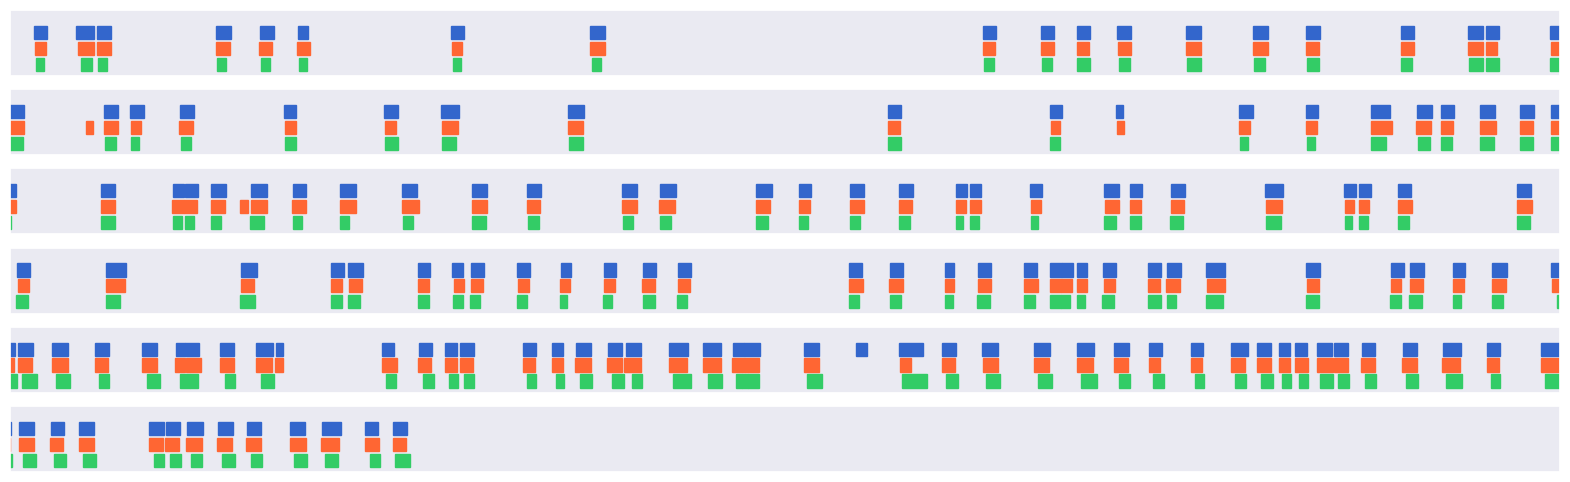

In [2]:
colors = [[0.2, 0.8, 0.4], [1, 0.4, 0.2], [0.2, 0.4, 0.8]]

clip_name = "1156-2023-01-13-15-15-36-93d791d5"

# Load data and features
ts, features, left_images, right_images = pf.load_imgs_and_features(clip_name)

# Load ground truth blinks
blink_on_idx, blink_off_idx, _ = pf.load_gt_blinks(clip_name, ts)

# Predict blinks with XGBoost and CNN
pred_on_xgb, pred_off_xgb = pf.xgb_predictions(features, ts)
pred_on_cnn, pred_off_cnn = pf.cnn_predictions(features, ts)

total_duration = np.ceil(len(ts)/200)
subplot_duration = 30  # duration of each subplot in seconds
num_subplots = int(np.ceil(total_duration / subplot_duration))

f, ax = plt.subplots(num_subplots, 1)
f.set_size_inches(20, 20 * num_subplots / 20)

time_intervals = [(i * 30, (i + 1) * 30) for i in range(num_subplots)]

for i, (start, end) in enumerate(time_intervals):
    pf.create_subplot(ax[i], blink_on_idx, blink_off_idx, pred_on_xgb, pred_off_xgb, pred_on_cnn, pred_off_cnn, start, end, colors)
    ax[i].xaxis.set_visible(False)
    ax[i].yaxis.set_visible(False)


In [31]:
data_dict = {}
clip_names = pf.get_clip_names()
clf = joblib.load("/users/tom/git/neon_blink_detection/weights/xgb.sav")

for clip_name in clip_names:
    print("Processing clip %s" %(clip_name))

    clip_data = {
        
        'confidence_probas_tp': [],
        'confidence_li_tp': [],
        'confidence_ri_tp': [],
        'confidence_blink_tp': [],

        'confidence_probas_fp': [],
        'confidence_li_fp': [],
        'confidence_ri_fp': [],
        'confidence_blink_fp': [],

        'true_positives': [],
        'false_positives': [],
    }

    _, pp_params = pf.get_params()

    pred_blink, gt_blinks, proba, li, ri, times = pf.get_blink_events(clip_name, clf)
    smoothed_proba = smooth_proba(proba, pp_params)
    
    iou_results, true_positives, false_negatives, false_positives = pf.compute_multiple_iou(gt_blinks, pred_blink)

    clip_data['true_positives'] = [(true_positives[x][0], tuple(times[np.array(true_positives[x][1])])) for x in range(len(true_positives))]

    clip_data['false_positives'] = [(false_positives[x][0], tuple(times[np.array(false_positives[x][1])])) for x in range(len(false_positives))]

    print("Number of false positives: {}".format(len(false_positives)))

    for i in range(len(true_positives)):
        start_idx = true_positives[i][1][0]
        end_idx = true_positives[i][1][1]

        confidence_blink_tmp, confidence_onset_tmp, confidence_offset_tmp = pf.compute_confidence(start_idx, end_idx, smoothed_proba)

        clip_data['confidence_blink_tp'].append(confidence_blink_tmp)
        clip_data['confidence_probas_tp'].append(smoothed_proba[start_idx:end_idx, :])  
        clip_data['confidence_li_tp'].append(li[start_idx:end_idx, :, :])
        clip_data['confidence_ri_tp'].append(ri[start_idx:end_idx, :, :])

    for i in range(len(false_positives)):
        start_idx = false_positives[i][1][0]
        end_idx = false_positives[i][1][1]

        confidence_blink_tmp, confidence_onset_tmp, confidence_offset_tmp = pf.compute_confidence(start_idx, end_idx, smoothed_proba)

        clip_data['confidence_blink_fp'].append(confidence_blink_tmp)
        clip_data['confidence_probas_fp'].append(smoothed_proba[start_idx:end_idx, :])
        clip_data['confidence_li_fp'].append(li[start_idx:end_idx, :, :])
        clip_data['confidence_ri_fp'].append(ri[start_idx:end_idx, :, :])

    data_dict[clip_name] = clip_data

Processing clip 2023-03-01_09-59-07-2ea49126
Number of false positives: 12
Processing clip 2023-01-27_15-59-54-49a115d5
Number of false positives: 3
Processing clip 2023-02-01_11-45-11-7621531e


In [ ]:
fig, ax = plt.subplots(1, 1)

ax.hist(clip_data['confidence_blink_tp'], bins=20, alpha=0.5, label="True Positives", density=False)
ax.hist(clip_data['confidence_blink_fp'], bins=20, alpha=0.5, label="False Positives", density=False)
ax.set_xlabel("Blink Confidence")
ax.set_ylabel("Count")
ax.legend(loc="upper right")
# ax.set_ylim(0, 10)

**CREATE VIDEO SHOWING CONFIDENCE AND PROBABILITIES**

In [9]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import HTML
import seaborn as sns
sns.set()

iclip = 5

confidence_blink = np.array(data_dict[clip_names[iclip]]['confidence_blink_tp'])
confidence_blink_sorted_idx = np.argsort(confidence_blink)

index = confidence_blink_sorted_idx[0]
print(index)

fig, axs = plt.subplots(2, 2)

video_left = data_dict[clip_names[iclip]]["confidence_li_tp"][index]
video_right = data_dict[clip_names[iclip]]["confidence_ri_tp"][index]

fig.set_size_inches(8, 6)
im0 = axs[0, 0].imshow(video_left[0, :, :], cmap='gray')
im1 = axs[0, 1].imshow(video_right[0, :, :], cmap='gray')
axs[0, 0].axis("off")
axs[0, 1].axis("off")

plt.close() 

axs[1, 0].plot(data_dict[clip_names[iclip]]['confidence_probas_tp'][index])
axs[1, 0].set_ylim(0, 1)
axs[1, 0].set_xlabel("Frame")
axs[1, 0].set_ylabel("Probability")
axs[1, 0].legend(["Bg", "On", "off"], loc="upper right")

# Create a vertical line object
vline = axs[1, 0].axvline(x=0, color=[0.5, 0.5, 0.5], linestyle=':')

axs[1, 1].text(0.5, 0.5, "Blink Confidence: %.2f" %(confidence_blink[index]), fontsize=14, ha='center')
axs[1, 1].text(0.5, 0.3, "Start: %.2f" %(data_dict[clip_names[iclip]]['true_positives'][index][0]), fontsize=12, ha='center')
# add clip name
axs[1, 1].text(0.5, 0.2, "Clip: %s" %(clip_names[iclip]), fontsize=12, ha='center')
axs[1, 1].axis("off")

def init():
    im0.set_data(video_left[0,:,:])
    im1.set_data(video_right[0,:,:])
    vline.set_xdata(0)

def animate(frame):
    im0.set_data(video_left[frame,:,:])
    im1.set_data(video_right[frame,:,:])
    vline.set_xdata(frame) # Update the vertical line position

    return im0, im1, vline

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=video_left.shape[0], interval=25)

# anim.save('/users/tom/blink_videos/false_positive_example_%.2f.mp4' %(confidence_blink[index]), extra_args=['-vcodec', 'libx264'])

HTML(anim.to_html5_video())


130


/tmp/ipykernel_1974539/2854225168.py:46: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  vline.set_xdata(0)
/tmp/ipykernel_1974539/2854225168.py:51: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  vline.set_xdata(frame) # Update the vertical line position


<font size = 4>**Load classifier weights and class probabilities**

In [10]:

from training.dataset_splitter import load_dataset_splitter
import warnings
warnings.filterwarnings("ignore")

with open("all_timestamps.pkl", "rb") as f:
    all_timestamps = pickle.load(f)
    
def compute_confidence(type="mean", prctile=None):
    
    tp_confidence = {}
    fp_confidence = {}

    fpr = {}
    br = {}
    blink_nr = {}

    dataset_splitter = load_dataset_splitter(n_clips=None, n_splits=5)
    for idx, (_, clip_tuples_val) in enumerate(dataset_splitter):

        if idx==0:
            continue

        clf = "/users/tom/git/neon_blink_detection/export-XGBClassifier-3-100320231148/n_lay5-lay_intv7-grid4-win15-trans0.0-scale0.0/weights-%d.sav" %idx

        all_probas = np.load("/users/tom/git/neon_blink_detection/export-XGBClassifier-3-100320231148/n_lay5-lay_intv7-grid4-win15-trans0.0-scale0.0/proba-%d.npy" %idx, allow_pickle=True)

        for clip_name in clip_tuples_val:

            tp_confidence[clip_name] = []
            fp_confidence[clip_name] = []

            try:

                pred_blink, gt_blinks, _, _, _ = pf.get_blink_events(clip_name, clf, all_probas[clip_name], all_timestamps)

                _, pp_params = pf.get_params()

                smoothed_proba = smooth_proba(all_probas[clip_name], pp_params)
                _, tp, fn, fp = pf.compute_multiple_iou(gt_blinks, pred_blink)

                fpr[clip_name], br[clip_name], blink_nr[clip_name] = pf.compute_fpr_and_br(clip_name, fp, tp, fn, all_timestamps)

                for i in range(len(tp)):
                    start_idx = tp[i][1][0]
                    end_idx = tp[i][1][1]

                    confidence_blink_tmp, _, _ = pf.compute_confidence(start_idx, end_idx, smoothed_proba, type=type, prctile=prctile)

                    tp_confidence[clip_name].append(confidence_blink_tmp)

                for i in range(len(fp)):
                    start_idx = fp[i][1][0]
                    end_idx = fp[i][1][1]

                    confidence_blink_tmp, _, _ = pf.compute_confidence(start_idx, end_idx, smoothed_proba, type=type, prctile=prctile)

                    fp_confidence[clip_name].append(confidence_blink_tmp)
                            
            except:
                print("No blink events found for clip %s" %clip_name)

    return tp_confidence, fp_confidence, fpr, br, blink_nr

tp_confidence, fp_confidence, fpr, br, blink_nr = compute_confidence(type="mean")

72 training clips & 17 validation clips.
No blink events found for clip 1202-2023-01-19-13-17-50-3651315a
No blink events found for clip 1290-2023-01-31-13-22-58-3ef10981
No blink events found for clip 1316-2023-02-03-09-34-09-31ef7938


<font size=4>**Plotting**

Plot histograms of blink rate, false positive rate and total number of blinks

Text(0.5, 0, 'Number of blinks')

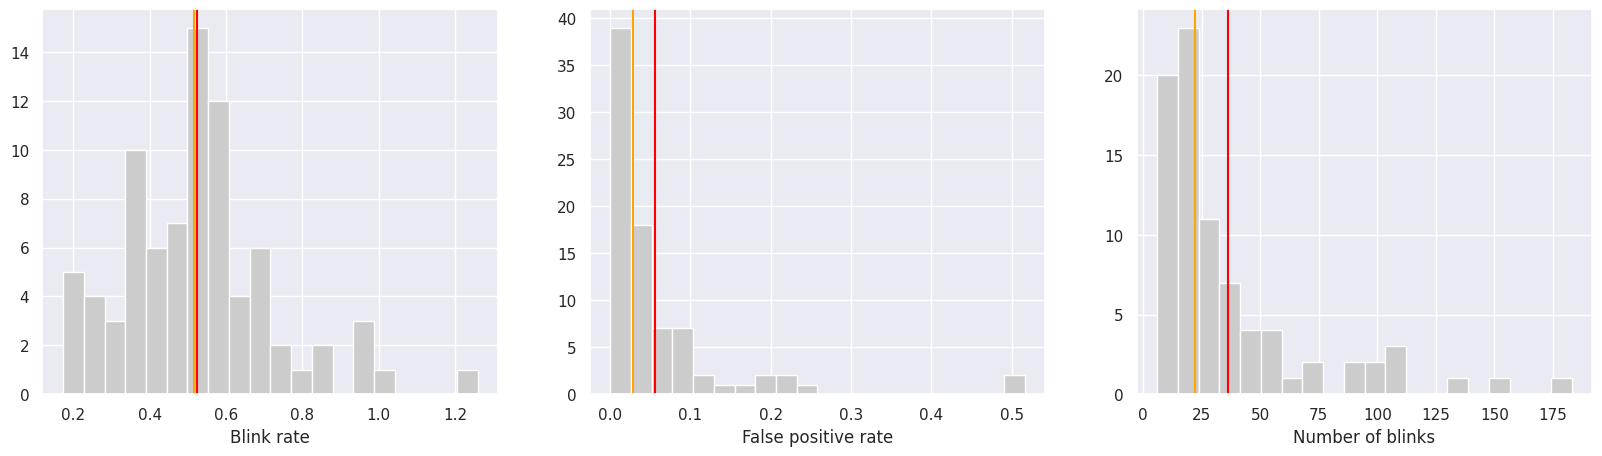

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3, figsize=(20, 5))

ax[0].hist(list(br.values()), bins=20, color=[0.8, 0.8, 0.8])
ax[0].axvline(np.mean(list(br.values())), color="red")
ax[0].axvline(np.median(list(br.values())), color="orange")
ax[0].set_xlabel("Blink rate")

ax[1].hist(list(fpr.values()), bins=20, color=[0.8, 0.8, 0.8])
ax[1].axvline(np.mean(list(fpr.values())), color="red")
ax[1].axvline(np.median(list(fpr.values())), color="orange")
ax[1].set_xlabel("False positive rate")

ax[2].hist(list(blink_nr.values()), bins=20, color=[0.8, 0.8, 0.8])
ax[2].axvline(np.mean(list(blink_nr.values())), color="red")
ax[2].axvline(np.median(list(blink_nr.values())), color="orange")
ax[2].set_xlabel("Number of blinks")

**Plot histgrams of true and false positives**

Subj 1152-2023-01-13-13-03-33-ddabe2a5: FPR = 0.52
Subj 1306-2023-02-02-10-44-25-4fec6abd: FPR = 0.51


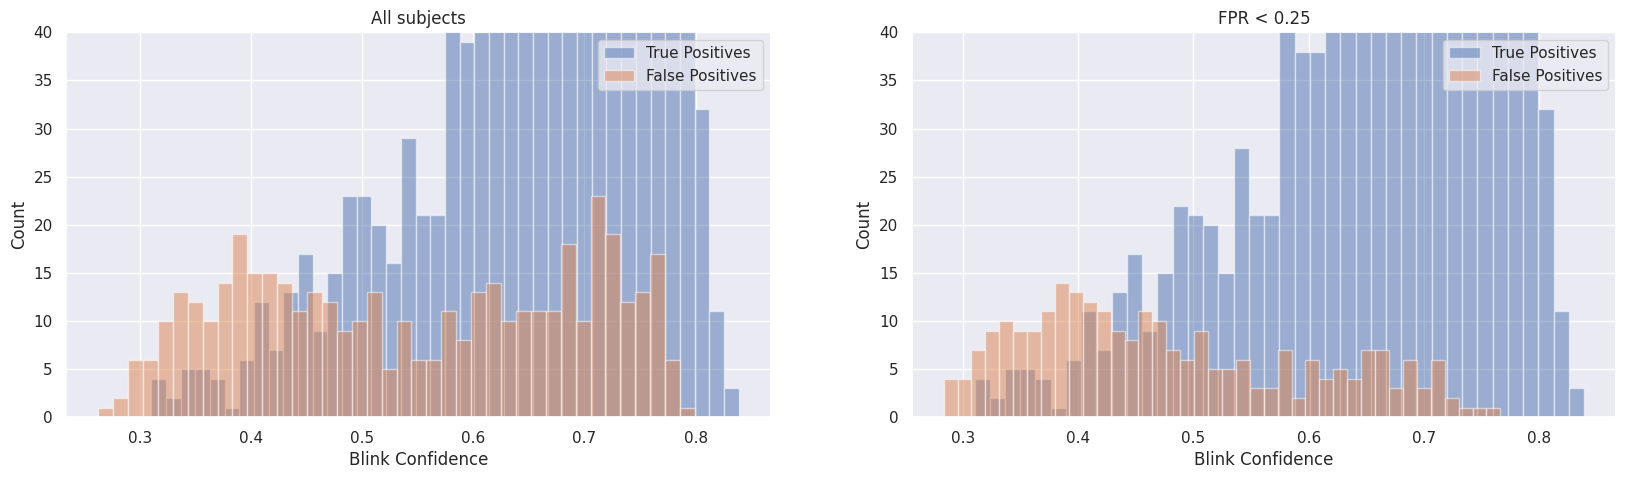

In [15]:
def plot_histogram_confidence(tp_confidence, fp_confidence, ax, title):

    ax.hist(tp_confidence, bins=40, alpha=0.5, label="True Positives", density=False)
    ax.hist(fp_confidence, bins=40, alpha=0.5, label="False Positives", density=False)
    ax.set_xlabel("Blink Confidence")
    ax.set_ylabel("Count")
    ax.legend(loc="upper right")
    ax.set_ylim(0, 40)
    ax.set_title(title)

true_pos_conf = np.concatenate([list(tp_confidence[x]) for x in tp_confidence.keys()])
false_pos_conf = np.concatenate([list(fp_confidence[x]) for x in tp_confidence.keys()])

f, ax = plt.subplots(1, 2, figsize=(20, 5))
plot_histogram_confidence(true_pos_conf, false_pos_conf, ax[0], "All subjects")

# extract subject ids with fpr < 0.25
fpr_threshold = 0.25
# -----------

subject_ids = []
for subject_id in fpr.keys():
    if fpr[subject_id] < fpr_threshold:
        subject_ids.append(subject_id)
    else:
        # print the subject id and fpr
        print("Subj %s: FPR = %.2f" %(subject_id, fpr[subject_id]))

true_pos_conf = []
false_pos_conf = []
for subject_id in subject_ids:
    true_pos_conf.extend(tp_confidence[subject_id])
    false_pos_conf.extend(fp_confidence[subject_id])

plot_histogram_confidence(true_pos_conf, false_pos_conf, ax[1], "FPR < %.2f" %fpr_threshold)

25 training clips & 6 validation clips.
No blink events found for clip 1316-2023-02-03-09-34-09-31ef7938
No blink events found for clip 1343-2023-02-07-11-37-02-214c1078
No blink events found for clip 1344-2023-02-07-13-19-49-d1517542
No blink events found for clip 1345-2023-02-07-13-19-29-f5930ed0


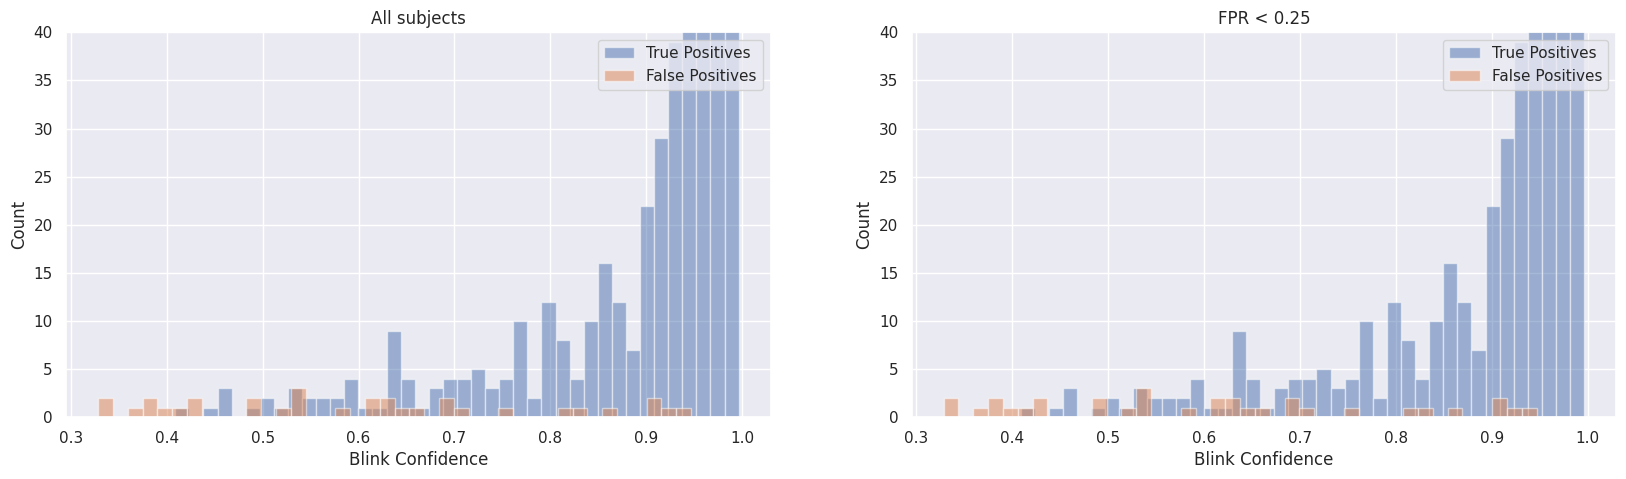

In [6]:
tp_confidence, fp_confidence, fpr, br, blink_nr = compute_confidence(type="percentile", prctile=0.25)

true_pos_conf = np.concatenate([list(tp_confidence[x]) for x in tp_confidence.keys()])
false_pos_conf = np.concatenate([list(fp_confidence[x]) for x in tp_confidence.keys()])

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(20, 5)

plot_histogram_confidence(true_pos_conf, false_pos_conf, ax[0], "All subjects")

# extract subject ids with fpr < 0.25
fpr_threshold = 0.25
subject_ids = []
for subject_id in fpr.keys():
    if fpr[subject_id] < fpr_threshold:
        subject_ids.append(subject_id)
    else:
        # print the subject id and fpr
        print("Subj %s: FPR = %.2f" %(subject_id, fpr[subject_id]))

# extract true positive confidence and false positive confidence for these subjects
true_pos_conf = []
false_pos_conf = []
for subject_id in subject_ids:
    true_pos_conf.extend(tp_confidence[subject_id])
    false_pos_conf.extend(fp_confidence[subject_id])

plot_histogram_confidence(true_pos_conf, false_pos_conf, ax[1], "FPR < %.2f" %fpr_threshold)

Text(0, 0.5, 'False positive rate')

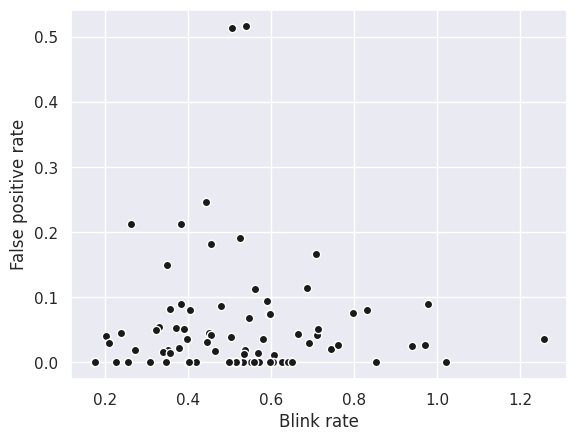

In [5]:
all_br = [br[x] for x in br.keys()]
all_fpr = [fpr[x] for x in fpr.keys()]

plt.scatter(all_br, all_fpr, ec="w", fc="k")
plt.xlabel("Blink rate")
plt.ylabel("False positive rate")   